In [49]:
#Load packages
library(reshape2)
library(ggplot2)
library(mongolite)
library(pheatmap)
#library(plotly)
library(vegan)
library(DESeq2)
library(knitr)
library(DT)

# Init connection to local mongodb
con <- mongo('WDI_countries', url = 'mongodb://mongo:27017/epidb')

ERROR: Error in exists(y, x, inherits = FALSE): invalid first argument


In [66]:
#### Read in data



## Jose Attribute data
#Create vector with names of Frank's variables
attribute_names = c(
    'AG.LND.AGRI.ZS',
    'AG.LND.AGRI.K2',
    'SP.DYN.CBRT.IN',
    'SP.DYN.CDRT.IN',
    'SH.STA.BFED.ZS',
    'SP.DYN.TFRT.IN',
    'TX.VAL.FOOD.ZS.UN',
    'TM.VAL.FOOD.ZS.UN',
    'NY.GDP.MKTP.KD.ZG',
    'NY.GDP.PCAP.CD',
    'SH.H2O.SAFE.UR.ZS',
    'SM.POP.TOTL.ZS',
    'ST.INT.ARVL',
    'SP.DYN.LE00.IN',
    'AG.PRD.LVSK.XD',
    'SH.DYN.NMRT',
    'SP.POP.65UP.TO.ZS',
    'SP.POP.GROW',
    'SP.POP.TOTL',
    'SI.POV.NAGP',
    'SM.POP.REFG.OR',
    'AG.SRF.TOTL.K2',
    'SP.URB.TOTL.IN.ZS',
    'SP.ADO.TFRT'
)

#Make dataframe from mongolite database with 2014 data
attData_all <- con$find('{"year" : "2014"}')

#Replace column names with something R-friendly
colnames(attData_all) <- gsub("-","_", colnames(attData_all), fixed=T)

#Write to clipboard and read in again to properly identify each column's type (a bit hacky)
write.table(attData_all, file="clipboard-256", sep="\t")
attData_all <- read.delim(file="clipboard-256")

#Get an overview
summary(attData_all)

 Imported 107389 records. Simplifying into dataframe...


             attr            value           
 AG.SRF.TOTL.K2:   247   Min.   :-3.301e+14  
 SP.POP.GROW   :   247   1st Qu.: 4.000e+00  
 SP.POP.TOTL   :   247   Median : 5.600e+01  
 AG.LND.TOTL.K2:   246   Mean   : 4.535e+12  
 EN.POP.DNST   :   246   3rd Qu.: 1.346e+08  
 SP.RUR.TOTL   :   245   Max.   : 1.103e+16  
 (Other)       :105911                       
                                               attr_name           year     
 Population growth (annual %)                       :   247   Min.   :2014  
 Population, total                                  :   247   1st Qu.:2014  
 Surface area (sq. km)                              :   247   Median :2014  
 Land area (sq. km)                                 :   246   Mean   :2014  
 Population density (people per sq. km of land area):   246   3rd Qu.:2014  
 Rural population                                   :   245   Max.   :2014  
 (Other)                                            :105911                 
   country_id   

In [53]:
#Subset to only get Frank's variables
attData_frank <- attData_all[attData_all$attr %in% attribute_names,]

#Get an overview
summary(attData_frank)

                attr          value           
 AG.SRF.TOTL.K2   : 247   Min.   :       -24  
 SP.POP.GROW      : 247   1st Qu.:         6  
 SP.POP.TOTL      : 247   Median :        44  
 SP.URB.TOTL.IN.ZS: 245   Mean   :  18268684  
 SM.POP.REFG.OR   : 232   3rd Qu.:      2618  
 SH.H2O.SAFE.UR.ZS: 228   Max.   :7260710677  
 (Other)          :1372                       
                                                            attr_name   
 Population growth (annual %)                                    : 247  
 Population, total                                               : 247  
 Surface area (sq. km)                                           : 247  
 Urban population (% of total)                                   : 245  
 Refugee population by country or territory of origin            : 232  
 Improved water source, urban (% of urban population with access): 228  
 (Other)                                                         :1372  
      year        country_id        coun

[1] 2818    6

In [102]:
#Make a wide-format dataframe with a single value per country per variable
attData_frank_wide <- dcast(attData_frank, country_id + country_name + year ~ attr, value.var="value")
#Export the data
write.table(attData_frank_wide, file="20170130_GS_FAO_attribute_data.txt", quote=F, row.names=F, sep="\t")
#Also prepare some summary statistics 
temp <- attData_frank_wide[,4:ncol(attData_frank_wide)]
temp2 <- data.frame(median=apply(temp,2,median, na.rm=T), mean=apply(temp,2,mean, na.rm=T), min=apply(temp,2,min, na.rm=T), max=apply(temp,2,max, na.rm=T))
temp2

,attr,name
1,SP.ADO.TFRT,"Adolescent fertility rate (births per 1,000 women ages 15-19)"
2,NY.GDP.MKTP.KD.ZG,GDP growth (annual %)
3,NY.GDP.PCAP.CD,GDP per capita (current US$)
4,SH.H2O.SAFE.UR.ZS,"Improved water source, urban (% of urban population with access)"
5,SH.DYN.NMRT,"Mortality rate, neonatal (per 1,000 live births)"
6,SP.POP.65UP.TO.ZS,Population ages 65 and above (% of total)
7,SP.POP.GROW,Population growth (annual %)
8,SP.POP.TOTL,"Population, total"
9,SM.POP.REFG.OR,Refugee population by country or territory of origin
10,AG.SRF.TOTL.K2,Surface area (sq. km)


,median,mean,min,max
AG.SRF.TOTL.K2,163610,3736773,2,134325255
NY.GDP.MKTP.KD.ZG,3.090773,3.199076,-24.000000,10.299983
NY.GDP.PCAP.CD,5977.3806,14081.8425,255.0446,116664.2625
SH.DYN.NMRT,11.00000,14.16447,0.70000,49.60000
SH.H2O.SAFE.UR.ZS,97.70000,94.94212,53.60000,100.00000
SH.STA.BFED.ZS,47.6,47.6,47.6,47.6
SI.POV.NAGP,6.835,13.187,1.600,49.300
SM.POP.REFG.OR,1509.0,516432.6,0.0,17531780.0
SP.ADO.TFRT,39.36882,47.61713,0.56080,203.60400
SP.POP.65UP.TO.ZS,6.100129,8.289291,1.039308,25.705422


In [94]:
head(attData_frank_wide, n=100)

,country_id,country_name,year,AG.SRF.TOTL.K2,NY.GDP.MKTP.KD.ZG,NY.GDP.PCAP.CD,SH.DYN.NMRT,SH.H2O.SAFE.UR.ZS,SH.STA.BFED.ZS,SI.POV.NAGP,SM.POP.REFG.OR,SP.ADO.TFRT,SP.POP.65UP.TO.ZS,SP.POP.GROW,SP.POP.TOTL,SP.URB.TOTL.IN.ZS,TM.VAL.FOOD.ZS.UN,TX.VAL.FOOD.ZS.UN
1,ABW,Aruba,2014,180,NA,NA,NA,98.1,NA,NA,NA,23.122,11.7535600003867,0.50396982061011,103441,41.779,NA,NA
2,ADO,Andorra,2014,470,NA,NA,1.5,100,NA,NA,7,NA,NA,-4.19194054987126,72786,85.633,NA,NA
3,AFG,Afghanistan,2014,652860,1.31253090783336,633.56924695192,36.1,78.2,NA,NA,2593368,76.7336,2.43468454325801,3.03347255254667,31627506,26.282,9.51326057195841,14.4956237464036
4,AGO,Angola,2014,1246700,NA,NA,49.6,75.4,NA,NA,9507,166.6028,2.30859331725355,3.26955240572046,24227524,43.274,NA,NA
5,ALB,Albania,2014,28750,2.16999999999989,4564.39033869288,6.5,94.9,NA,NA,10140,21.4896,12.0622519618116,-0.0998300968586222,2894475,56.409,10.3262176054404,3.00290920278718
6,ARB,Arab World,2014,13152838.5,2.22165014544402,7386.4284437148,17.955758037425,92.6122004798051,NA,NA,6171232,48.2281529997765,4.26227212098414,2.16809873520243,385272539,57.3884565369192,NA,NA
7,ARE,United Arab Emirates,2014,83600,4.57028972121714,43962.713693201,3.6,99.6,NA,NA,90,29.2538,1.03930833547671,0.509332470845006,9086139,85.266,NA,NA
8,ARG,Argentina,2014,2780400,0.45360547903708,12509.5311180615,6.5,98.9,NA,NA,318,63.8512,10.8089836893072,1.03305555285726,42980026,91.604,2.43119437333066,55.8739120379145
9,ARM,Armenia,2014,29740,3.49999999999989,3873.53356580682,7.7,100,NA,NA,11850,23.5084,10.5795977185467,0.465529171376968,3006154,62.812,19.5126633357618,31.7615739853845
10,ASM,American Samoa,2014,200,NA,NA,NA,100,NA,NA,NA,NA,NA,0.23840496770808,55434,87.264,NA,NA


In [62]:
#Make a scatterplot for data overview

#Corrplot
test3 <- data.frame(attData_frank_wide[,4:ncol(attData_frank_wide)], row.names = attData_frank_wide$country_id)
#plot(hclust(dist(t(test3))))

#Count number of missing values (NA) in each column
missing_count <- colSums(is.na(test3)*1)
missing_count

AG.SRF.TOTL.K2 NY.GDP.MKTP.KD.ZG    NY.GDP.PCAP.CD       SH.DYN.NMRT 
                0                33                32                22 
SH.H2O.SAFE.UR.ZS    SH.STA.BFED.ZS       SI.POV.NAGP    SM.POP.REFG.OR 
               19               246               237                15 
      SP.ADO.TFRT SP.POP.65UP.TO.ZS       SP.POP.GROW       SP.POP.TOTL 
               20                20                 0                 0 
SP.URB.TOTL.IN.ZS TM.VAL.FOOD.ZS.UN TX.VAL.FOOD.ZS.UN 
                2               120               121

,missing_count
AG.SRF.TOTL.K2,0
NY.GDP.MKTP.KD.ZG,33
NY.GDP.PCAP.CD,32
SH.DYN.NMRT,22
SH.H2O.SAFE.UR.ZS,19
SH.STA.BFED.ZS,246


In [ ]:
#Only retain variables where at least half the countries has a non-missing value
head(test3)
test4 <- test3[,missing_count <= nrow(test3)*0.5]
head(test4)

,AG.SRF.TOTL.K2,NY.GDP.MKTP.KD.ZG,NY.GDP.PCAP.CD,SH.DYN.NMRT,SH.H2O.SAFE.UR.ZS,SM.POP.REFG.OR,SP.ADO.TFRT,SP.POP.65UP.TO.ZS,SP.POP.GROW,SP.POP.TOTL,SP.URB.TOTL.IN.ZS,TM.VAL.FOOD.ZS.UN,TX.VAL.FOOD.ZS.UN
AG.SRF.TOTL.K2,1.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.2308120,0.8802428,0.0000000,0.0000000,0.0000000
NY.GDP.MKTP.KD.ZG,0,1,0,0,0,0,0,0,0,0,0,0,0
NY.GDP.PCAP.CD,0,0,1,0,0,0,0,0,0,0,0,0,0
SH.DYN.NMRT,0,0,0,1,0,0,0,0,0,0,0,0,0
SH.H2O.SAFE.UR.ZS,0,0,0,0,1,0,0,0,0,0,0,0,0
SM.POP.REFG.OR,0,0,0,0,0,1,0,0,0,0,0,0,0
SP.ADO.TFRT,0,0,0,0,0,0,1,0,0,0,0,0,0
SP.POP.65UP.TO.ZS,0,0,0,0,0,0,0,1,0,0,0,0,0
SP.POP.GROW,0.2308120,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,1.0000000,0.1723769,0.0000000,0.0000000,0.0000000
SP.POP.TOTL,0.8802428,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.1723769,1.0000000,0.0000000,0.0000000,0.0000000


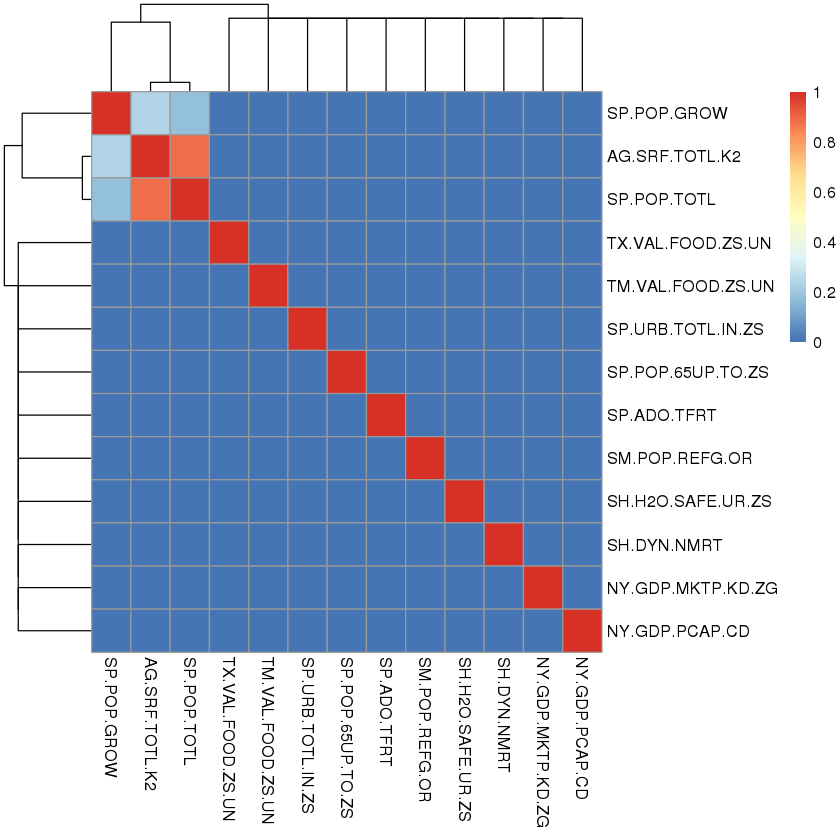

In [219]:
#Visualize the remaining variables (inspect for confounders)
#plot(test4[,1:8])

#Correlate all variables
test4_cor <- cor(test4, method="spearman")
#Replace missing correlations with zeros
test4_cor[is.na(test4_cor)] <- 0
#Visualize variable correlations
pheatmap(test4_cor)

data.frame(test4_cor)


In [99]:
## Heike residue data
data_residue <- read.delim(file="residue_all_drugs_combined2.txt", na.strings=c("<5", "<50", "<25", "<100", "<20", "<500", "ntb"), check.names=F)

data_residue[is.na.data.frame(data_residue)] <- 0

dim(data_residue)


[1] 62 91